# MNIST classifier in pytorch

References: 
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [38]:
#!pip install optuna

In [1]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

from torch.utils.tensorboard import SummaryWriter

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import optuna

## Load MNIST train, validation and test datasets

In [2]:
def get_mnist(batchsize):
    
    # transformer for the images
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    
    trainset_all = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)

    # train validation sets sizes
    lengths = [int(len(trainset_all)*0.8), int(len(trainset_all)*0.2)]

    # seed for reproducibility
    seed = 47

    trainset, validationset = random_split(trainset_all, lengths, generator=torch.Generator().manual_seed(seed))

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                              shuffle=True, num_workers=1)

    validationloader = torch.utils.data.DataLoader(validationset, batch_size=batchsize,
                                              shuffle=True, num_workers=1)

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                             shuffle=False, num_workers=1)
    
    return trainset, validationset, testset, trainloader, validationloader, testloader


# get images
trainset, validationset, testset, trainloader, validationloader, testloader = get_mnist(batchsize=4)

In [3]:
classes = torchvision.datasets.MNIST.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Show some example images

torch.Size([4, 1, 28, 28]) tensor([0, 1, 3, 0])


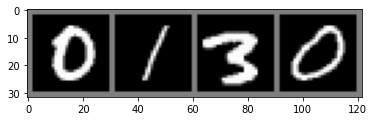

0 - zero 1 - one 3 - three 0 - zero


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape, labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [5]:
print(len(trainset))
print(len(validationset))
print(len(testset))

48000
12000
10000


## Define Network

In [6]:
class Net(nn.Module):
    def __init__(self, input_size=(1,1,28,28)):
        super(Net, self).__init__()
        
        # input size is : (batch_size, channels, width, height)
        self.input_size = input_size
        self.width = input_size[2]
        self.height = input_size[3]
        self.channels = input_size[1]
        
        self.conv1 = nn.Conv2d(in_channels=self.channels, out_channels=6, kernel_size=5)
        
        h1_out = self.calculate_size(self.width, 5, 1, 1, 0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        h2_out = self.calculate_size(int(h1_out/2), 5, 1, 1, 0)
        
        self.fc1 = nn.Linear(in_features=16 * int(h2_out/2) * int(h2_out/2), out_features=120)     
        self.fc2 = nn.Linear(in_features=120, out_features=84)     
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
       
        x = F.relu(self.conv1(x))  
        x = self.pool(x)     
        x = F.relu(self.conv2(x))     
        x = self.pool(x)
        
        h1_out = self.calculate_size(self.width, 5, 1, 1, 0)
        h2_out = self.calculate_size(int(h1_out/2), 5, 1, 1, 0)
       
        x = x.view(-1, 16 * int(h2_out/2) * int(h2_out/2))       
        x = F.relu(self.fc1(x))       
        x = F.relu(self.fc2(x))       
        x = self.fc3(x)       
        return x
    
    def calculate_size(self, size_in, kernel_size, dilatation, stride, padding):
        # see https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        nominator = size_in + 2*padding - dilatation*(kernel_size-1) -1
        size_out = int(np.floor(nominator/stride +1))
        return size_out
        
def create_model():
    return Net()


## Hyperparameter search 

Let's use [Optuna](https://optuna.org/)

Code reference for an Optuna example: https://github.com/optuna/optuna/blob/master/examples/pytorch_simple.py

In [7]:
torch.manual_seed(12345)
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Hyperparameter used:
# learning rate
# batchsize
# optimizer type


def objective(trial):
    
    epochs = 2
    # Generate the model.
    model = create_model().to(device)
    
    criterion = nn.CrossEntropyLoss()

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the MNIST dataset using batchsize hyperparameter
    batchsize = trial.suggest_categorical('batchsize', [4, 16])
    trainset, validationset, testset, trainloader, validationloader, testloader = get_mnist(batchsize)
    
    n_train_examples = len(trainset)
    n_validation_examples = len(validationset)

    # Training of the model.
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # Limiting training data for faster epochs.
            if batch_idx * batchsize >= n_train_examples:
                break

            #data = data.view(data.size(0), -1).to(device)
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0.0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validationloader):
                # Limiting validation data.
                if batch_idx * batchsize >= n_validation_examples:
                    break
                #data, target = data.view(data.size(0), -1).to(device), target.to(device)
                data = data.to(device)
                target = target.to(device)
                
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(validationloader.dataset), n_validation_examples)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [18]:
# Run hyper parameter search

# try 3 times
n_trials = 3

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-09-02 16:21:34,496] Trial 0 finished with value: 0.8989166666666667 and parameters: {'optimizer': 'RMSprop', 'lr': 1.1695005681741882e-05, 'batchsize': 4}. Best is trial 0 with value: 0.8989166666666667.
[I 2020-09-02 16:22:12,738] Trial 1 finished with value: 0.9820833333333333 and parameters: {'optimizer': 'SGD', 'lr': 0.02964495377359948, 'batchsize': 16}. Best is trial 1 with value: 0.9820833333333333.
[I 2020-09-02 16:22:58,290] Trial 2 finished with value: 0.8948333333333334 and parameters: {'optimizer': 'SGD', 'lr': 0.002349685526187193, 'batchsize': 16}. Best is trial 1 with value: 0.9820833333333333.


Study statistics: 
  Number of finished trials:  3
  Number of pruned trials:  0
  Number of complete trials:  3
Best trial:
  Value:  0.9820833333333333
  Params: 
    optimizer: SGD
    lr: 0.02964495377359948
    batchsize: 16


## Use Best Parameters

In [24]:
model = create_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0296)
batchsize = 16
epochs = 8

## Training Loop

In [20]:
def validate(model, criterion, dataloader, summary_writer, batch_idx, epoch, device):
    # validation mode
    model.eval() 
    
    correct = 0.0
    total = 0.0
    running_loss = 0.0
    
    with torch.no_grad(): #gradients should not eval        
        for i, (data, target) in enumerate(dataloader):
            
            data = data.to(device)
            target = target.to(device)      
            
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            
            max_proba, predicted = torch.max(output.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
    accuracy = correct / total
        
    summary_writer.add_scalar('Loss/validation',
                running_loss,
                epoch * len(dataloader) + batch_idx)

    summary_writer.add_scalar('Accuracy/validation', 
                accuracy, 
                epoch * len(dataloader) + batch_idx)

    print('[%d, %5d] validation loss: %.3f validation accuracy: %3f' %
          (epoch + 1, batch_idx + 1, running_loss, accuracy))
        
    model.train()
    return summary_writer


def train(model, optimizer, criterion, trainloader, validationloader, writer, epochs, device):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        correct = 0.0
        total = 0.0
        for i, (data, target) in enumerate(trainloader, 0):
            
            data = data.to(device)
            target = target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_proba, predicted = torch.max(output.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))

                print('[%d, %5d] accuracy: %.3f' %
                      (epoch + 1, i + 1, correct/total))

                running_loss = 0.0
                total = 0.0
                correct = 0.0
                
                # evaluate validation data
                validate(model, criterion, validationloader, SummaryWriter(), i, epoch, device)

    print('Finished Training')
    return model
      

In [25]:
trainset, validationset, testset, trainloader, validationloader, testloader = get_mnist(batchsize)

# Statistics Writer for Tensorboard
writer = SummaryWriter()
epochs = 8

model = train(model, optimizer, criterion, trainloader, validationloader, writer, epochs=epochs, device=device)

[1,  2000] loss: 0.453
[1,  2000] accuracy: 0.851
[1,  2000] validation loss: 76.339 validation accuracy: 0.967333
[2,  2000] loss: 0.071
[2,  2000] accuracy: 0.978
[2,  2000] validation loss: 47.076 validation accuracy: 0.980000
[3,  2000] loss: 0.049
[3,  2000] accuracy: 0.985
[3,  2000] validation loss: 37.557 validation accuracy: 0.982417
[4,  2000] loss: 0.036
[4,  2000] accuracy: 0.988
[4,  2000] validation loss: 47.188 validation accuracy: 0.980917
[5,  2000] loss: 0.029
[5,  2000] accuracy: 0.991
[5,  2000] validation loss: 31.135 validation accuracy: 0.987667
[6,  2000] loss: 0.025
[6,  2000] accuracy: 0.993
[6,  2000] validation loss: 31.424 validation accuracy: 0.986667
[7,  2000] loss: 0.019
[7,  2000] accuracy: 0.993
[7,  2000] validation loss: 30.260 validation accuracy: 0.987333
[8,  2000] loss: 0.016
[8,  2000] accuracy: 0.995
[8,  2000] validation loss: 26.926 validation accuracy: 0.989917
Finished Training


## Save trained network

In [26]:
PATH = './mnist_net.pth'
torch.save(model.state_dict(), PATH)

## Predict test data with the trained network

In [27]:
# Load the trained model
model = create_model()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
# predict test images and calculate statistics

def predict(net, loader, labels):
    
    n = len(labels)
    classes_preds = {c: np.zeros(n, dtype=np.int32) for c in range(10)}
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            total += labels.size(0)
            correct += c.sum().item()

            for i in range(labels.size(0)):
                label = labels[i]
                l = label.item()
                pred = predicted[i].item()
                p = classes_preds[l]
                p[pred] +=1                  
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
    return classes_preds, correct, total, class_correct, class_total


In [30]:
# predict test data and plot confusion matrix and accuracy per class
labels = np.arange(10)
classes_preds, correct, total, class_correct, class_total = predict(model, testloader, labels)
test_df = pd.DataFrame.from_dict(classes_preds, orient='index', columns=classes_preds.keys())
test_df

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,0,1,2,0
1,0,1130,1,0,0,2,0,1,1,0
2,0,2,1026,0,0,0,0,3,1,0
3,0,1,6,989,0,10,0,3,1,0
4,1,0,1,0,974,0,2,0,0,4
5,2,0,0,2,0,886,1,1,0,0
6,11,3,2,0,3,4,934,0,1,0
7,0,5,5,0,0,0,0,1017,1,0
8,1,1,5,1,0,3,0,4,958,1
9,1,1,2,0,7,4,0,5,2,987


## Confusion Matrix

In [31]:
def plot_confusion_matrix(conf_df, title, fmt='.0f'):

    fig, ax = plt.subplots(figsize=(10, 9))
    ax.set_title(title, fontsize=16)
    ano = True if conf_df.shape[0] < 100 else False
    sns.heatmap(conf_df, annot=ano, fmt=fmt, ax=ax, cmap='Blues', cbar=False,
                linewidths=.1, linecolor='black', square=True)
    plt.ylabel('True Class', fontsize=16)
    plt.xlabel('Predicted Class', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.yticks(rotation=0) 
    plt.tight_layout()
    plt.show()

    return

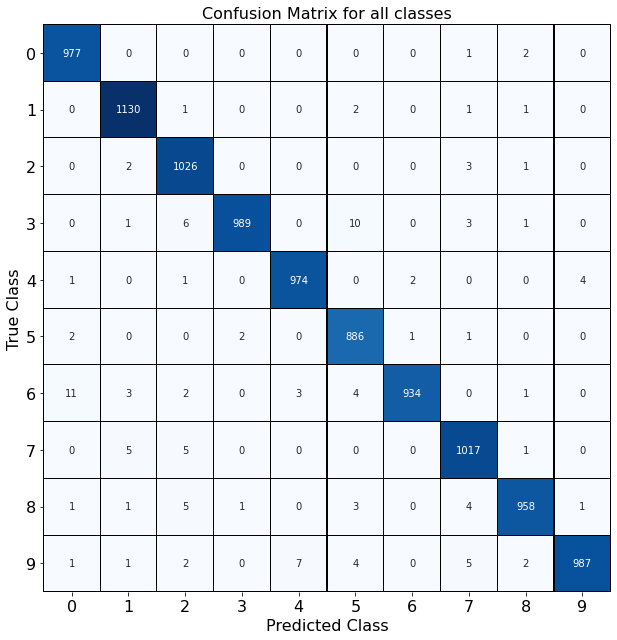

Accuracy of 0 - zero : 99 %
Accuracy of 1 - one : 99 %
Accuracy of 2 - two : 99 %
Accuracy of 3 - three : 97 %
Accuracy of 4 - four : 99 %
Accuracy of 5 - five : 99 %
Accuracy of 6 - six : 97 %
Accuracy of 7 - seven : 98 %
Accuracy of 8 - eight : 98 %
Accuracy of 9 - nine : 97 %

Total accuracy of the network on the 10000 test images: 98 %


In [32]:
np.set_printoptions(precision=2)

plot_confusion_matrix(test_df, 'Confusion Matrix for all classes')

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('')
print(f'Total accuracy of the network on the {total} test images: %d %%' % (
    100 * correct / total))

##  Tensorboard data

On commandline run `tensorboard --logdir=runs` 

and open http://localhost:6006/

See https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html


or uncomment the last 2 cells


In [33]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor

def get_preds_probs(model, testloader):
    class_probs = []
    class_preds = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            output = model(images)
            class_probs_batch = [F.softmax(el, dim=0) for el in output]
            _, class_preds_batch = torch.max(output, 1)

            class_probs.append(class_probs_batch)
            class_preds.append(class_preds_batch)
    return class_probs, class_preds


def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()


class_probs, class_preds = get_preds_probs(model, testloader)
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)#

In [36]:
# %load_ext tensorboard

In [37]:
# %tensorboard --logdir=runs